In [1]:
"""
 Convolutional Neural Network (CNN) with MNIST
 @Sungjoon Choi (sungjoon.choi@cpslab.snu.ac.kr
 based on "https://github.com/aymericdamien/TensorFlow-Examples/"
"""
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("Packs loaded")

Packs loaded


In [2]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("MNIST ready")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
MNIST ready


# Define convolutional neural network (CNN)

In [3]:
# Network
with tf.device('/gpu:1'): # <= This is optional
    n_input  = 784
    n_output = 10
    weights  = {
        'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64], stddev=0.1)),
        'wd1': tf.Variable(tf.random_normal([14*14*64, n_output], stddev=0.1))
    }
    biases   = {
        'bc1': tf.Variable(tf.random_normal([64], stddev=0.1)),
        'bd1': tf.Variable(tf.random_normal([n_output], stddev=0.1))
    }
    def conv_simple(_input, _w, _b):
        # Reshape input
        _input_r = tf.reshape(_input, shape=[-1, 28, 28, 1])
        # Convolution
        _conv1 = tf.nn.conv2d(_input_r, _w['wc1'], strides=[1, 1, 1, 1], padding='SAME')
        # Add-bias
        _conv2 = tf.nn.bias_add(_conv1, _b['bc1'])
        # Pass ReLu
        _conv3 = tf.nn.relu(_conv2)
        # Max-pooling
        _pool  = tf.nn.max_pool(_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        # Vectorize
        _dense = tf.reshape(_pool, [-1, _w['wd1'].get_shape().as_list()[0]])
        # Fully-connected layer
        _out = tf.add(tf.matmul(_dense, _w['wd1']), _b['bd1'])
        # Return everything
        out = {
            'input_r': _input_r, 'conv1': _conv1, 'conv2': _conv2, 'conv3': _conv3
            , 'pool': _pool, 'dense': _dense, 'out': _out
        }
        return out
print ("CNN ready")

CNN ready


# Define computational graph

In [4]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_output])
# Parameters
learning_rate   = 0.001
training_epochs = 5
batch_size      = 100
display_step    = 1
# Functions! 
with tf.device('/gpu:1'): # <= This is optional
    _pred = conv_simple(x, weights, biases)['out']
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(_pred, y))
    optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    _corr = tf.equal(tf.argmax(_pred,1), tf.argmax(y,1)) # Count corrects
    accr = tf.reduce_mean(tf.cast(_corr, tf.float32)) # Accuracy
    init = tf.initialize_all_variables()
# Saver 
save_step = 1;
savedir = "nets/"
saver = tf.train.Saver(max_to_keep=training_epochs) 
print ("Network Ready to Go!")

Network Ready to Go!


# Actual CNN optimization 

In [5]:
do_train = 1

# Do some optimizations
sess = tf.Session()
sess.run(init)

if do_train == 1:
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch

        # Display logs per epoch step
        if epoch % display_step == 0: 
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
            print (" Training accuracy: %.3f" % (train_acc))
            test_acc = sess.run(accr, feed_dict={x: testimg, y: testlabel})
            print (" Test accuracy: %.3f" % (test_acc))

        # Save Net
        if epoch % save_step == 0:
            saver.save(sess, "nets/cnn_simple.ckpt-" + str(epoch))

    print ("Optimization Finished.")

Epoch: 000/005 cost: 0.327559794
 Training accuracy: 0.970
 Test accuracy: 0.953
Epoch: 001/005 cost: 0.108890321
 Training accuracy: 0.990
 Test accuracy: 0.974
Epoch: 002/005 cost: 0.072374471
 Training accuracy: 0.980
 Test accuracy: 0.979
Epoch: 003/005 cost: 0.057082940
 Training accuracy: 0.990
 Test accuracy: 0.980
Epoch: 004/005 cost: 0.047584373
 Training accuracy: 0.970
 Test accuracy: 0.981
Optimization Finished.


In [6]:
# Restore trained network
ckpt = tf.train.get_checkpoint_state(savedir)
if ckpt and ckpt.model_checkpoint_path:
    epoch = 4
    saver.restore(sess, "nets/cnn_simple.ckpt-" + str(epoch))

In [7]:
# Now let's see what all variables looks like 
with tf.device('/gpu:1'):
    conv_out = conv_simple(x, weights, biases)

input_r = sess.run(conv_out['input_r'], feed_dict={x: trainimg[0:1, :]})
conv1   = sess.run(conv_out['conv1'], feed_dict={x: trainimg[0:1, :]})
conv2   = sess.run(conv_out['conv2'], feed_dict={x: trainimg[0:1, :]})
conv3   = sess.run(conv_out['conv3'], feed_dict={x: trainimg[0:1, :]})
pool    = sess.run(conv_out['pool'], feed_dict={x: trainimg[0:1, :]})
dense   = sess.run(conv_out['dense'], feed_dict={x: trainimg[0:1, :]})
out     = sess.run(conv_out['out'], feed_dict={x: trainimg[0:1, :]})

# Input

Size of 'input_r' is (1, 28, 28, 1)
Label is 7


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


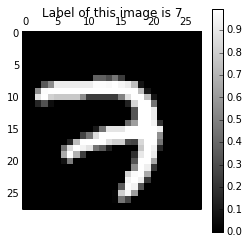

In [8]:
# Let's see 'input_r'
print ("Size of 'input_r' is %s" % (input_r.shape,))
label = np.argmax(trainlabel[0, :])
print ("Label is %d" % (label))

# Plot ! 
plt.matshow(input_r[0, :, :, 0], cmap=plt.get_cmap('gray'))
plt.title("Label of this image is " + str(label) + "")
plt.colorbar()
plt.show()

# Conv1 (convolution)

Size of 'conv1' is (1, 28, 28, 64)


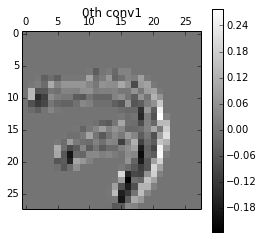

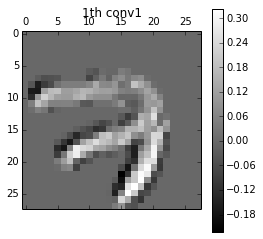

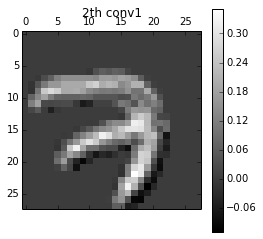

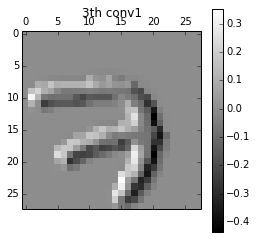

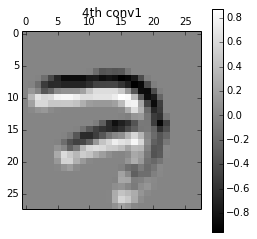

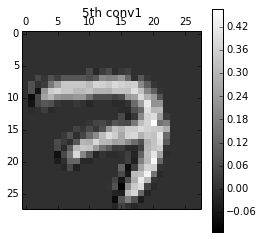

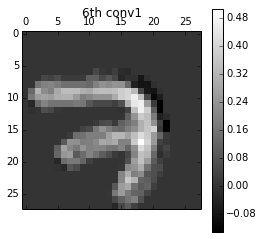

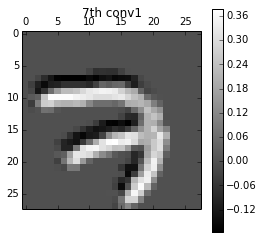

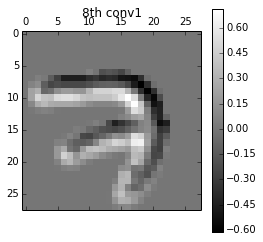

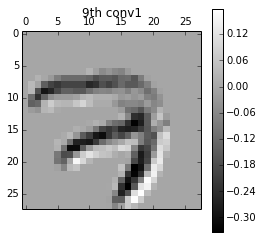

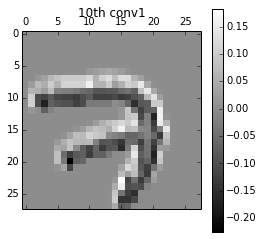

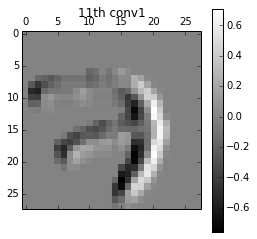

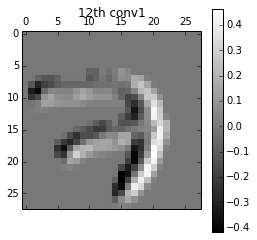

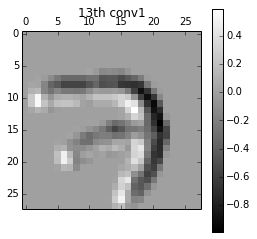

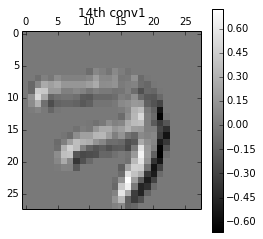

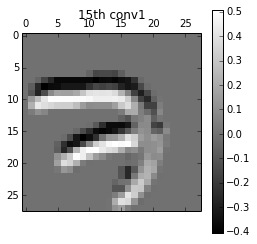

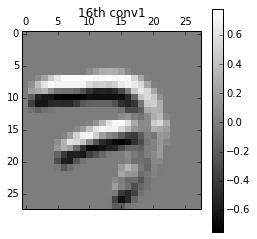

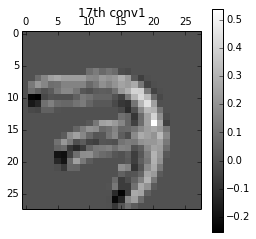

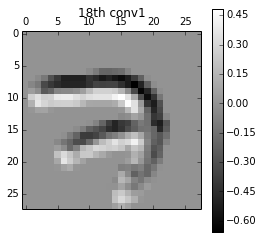

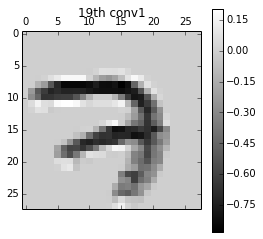

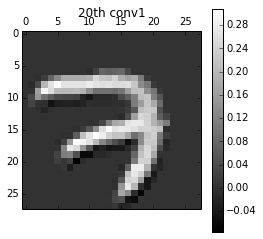

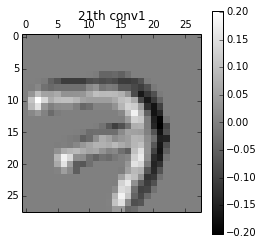

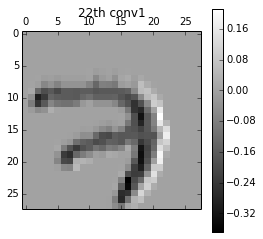

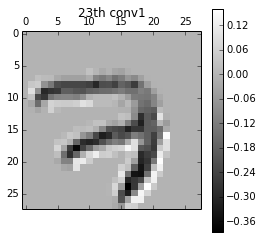

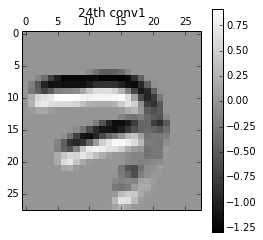

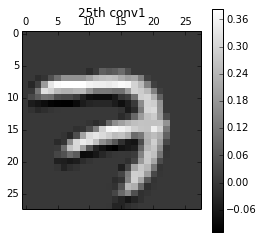

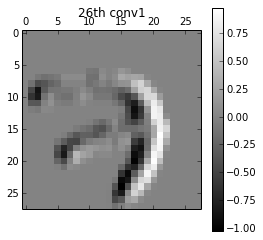

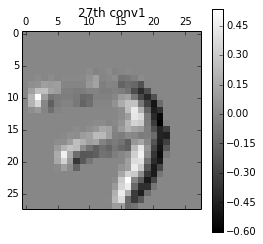

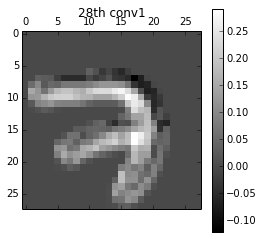

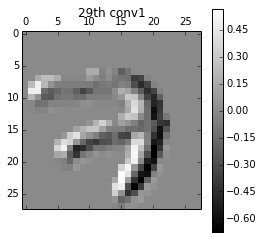

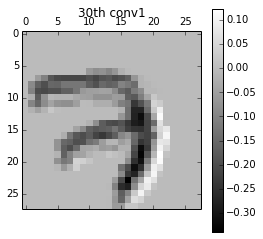

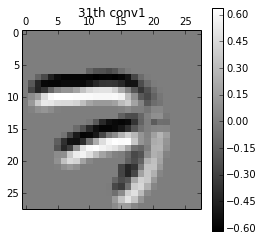

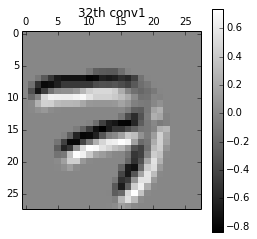

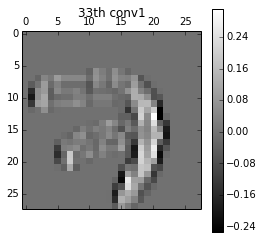

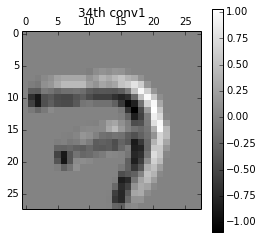

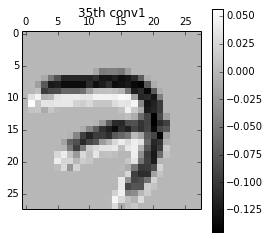

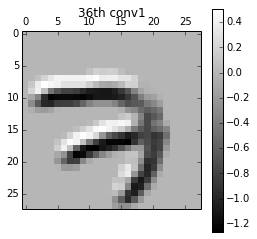

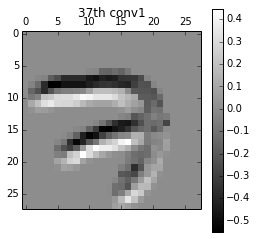

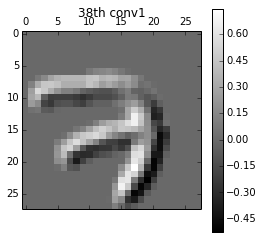

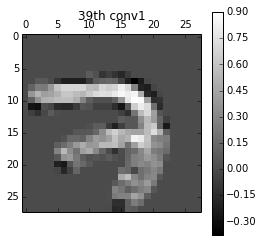

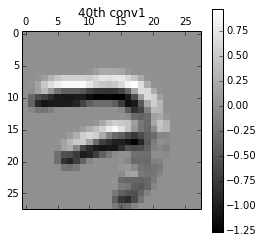

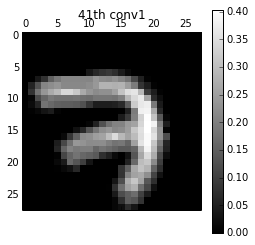

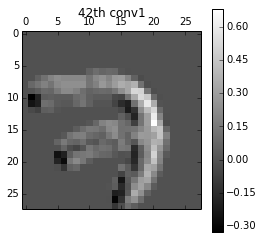

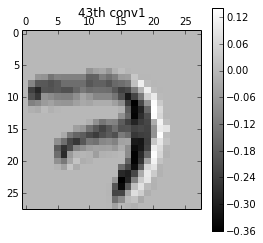

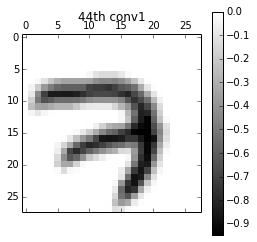

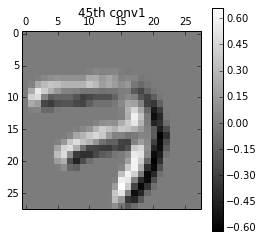

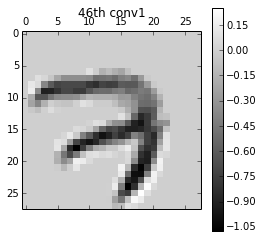

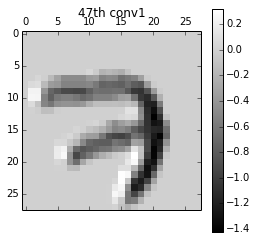

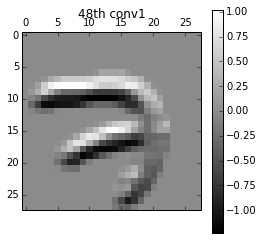

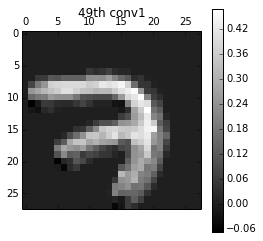

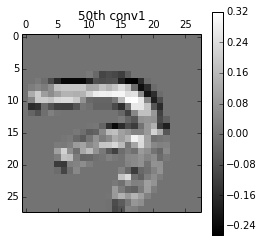

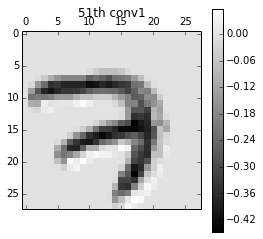

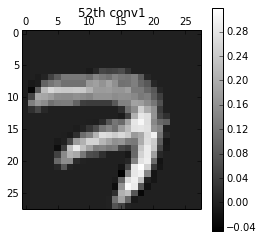

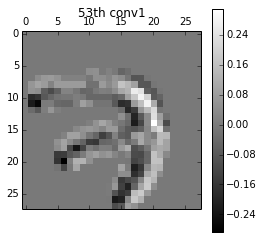

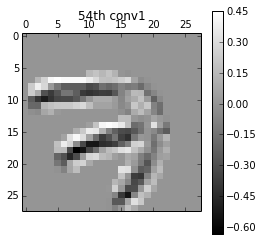

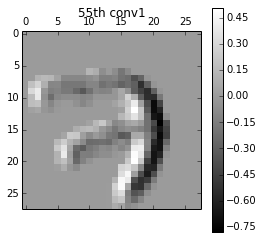

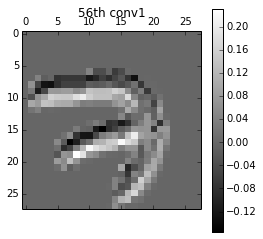

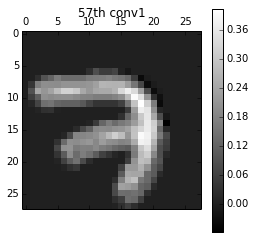

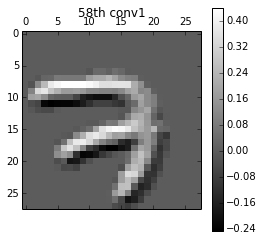

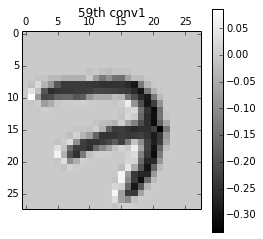

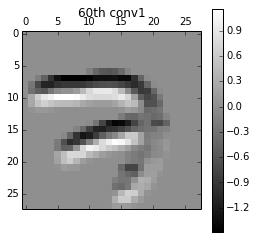

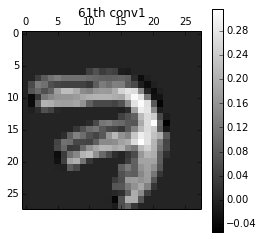

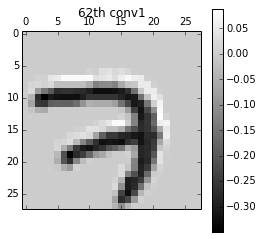

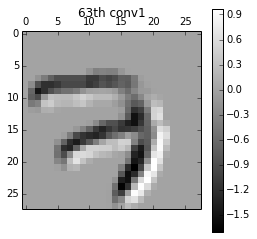

In [9]:
# Let's see 'conv1'
print ("Size of 'conv1' is %s" % (conv1.shape,))

# Plot ! 
for i in range(64):
    plt.matshow(conv1[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv1")
    plt.colorbar()
    plt.show() 

# Conv2 (+bias)

Size of 'conv2' is (1, 28, 28, 64)


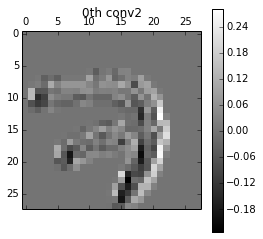

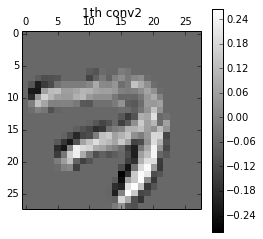

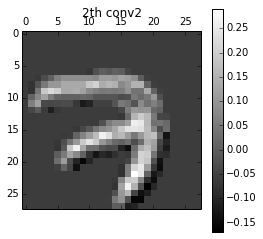

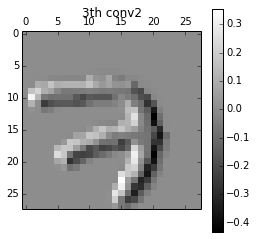

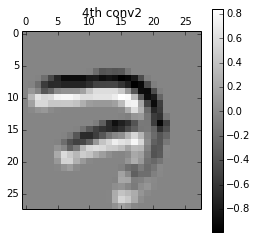

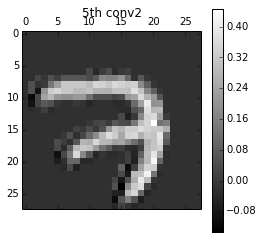

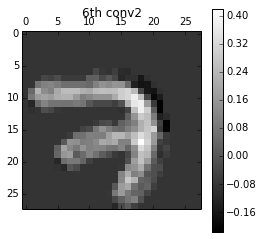

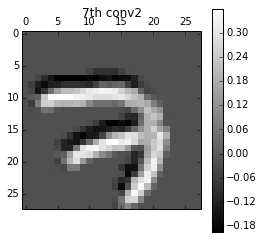

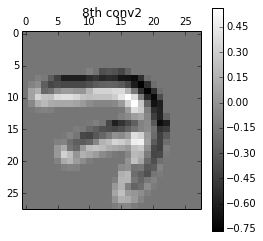

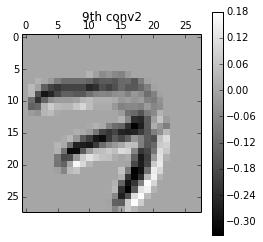

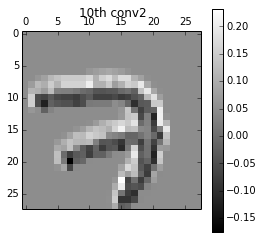

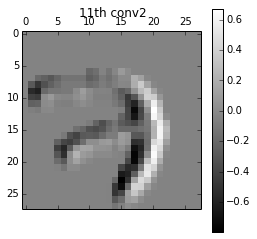

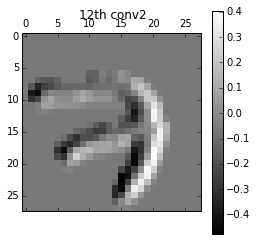

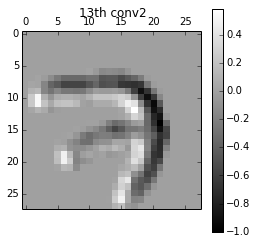

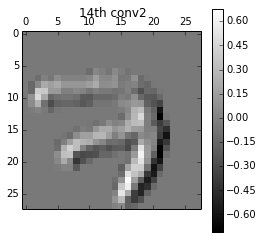

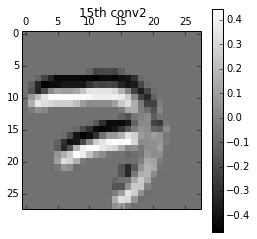

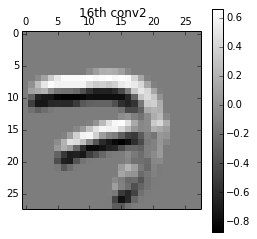

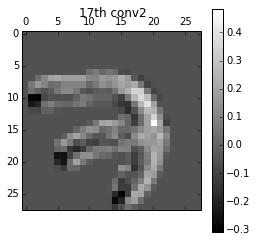

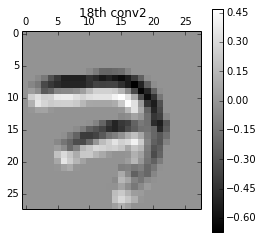

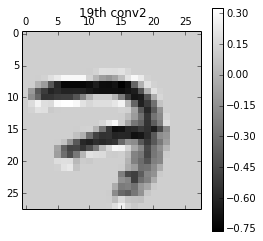

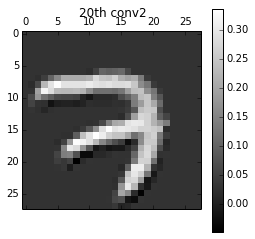

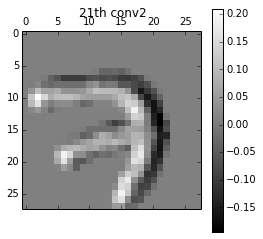

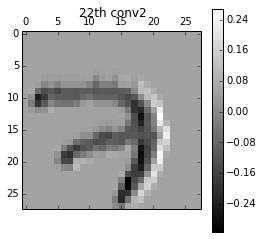

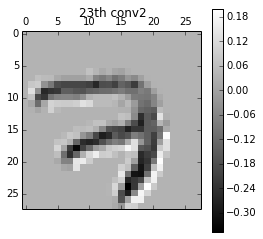

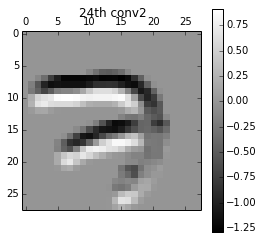

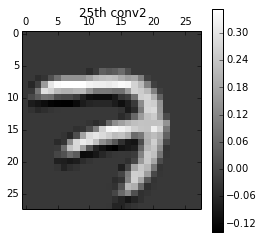

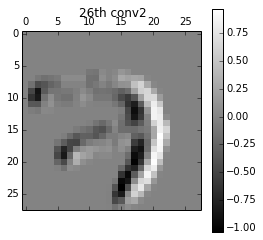

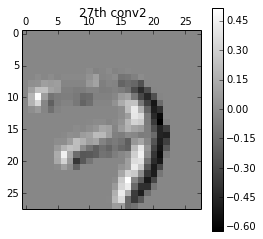

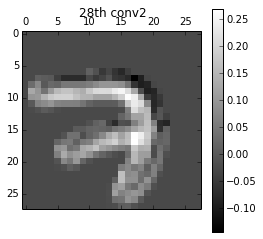

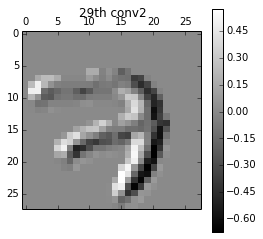

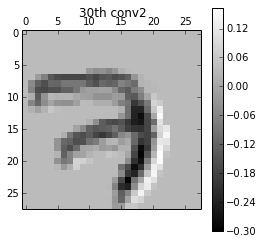

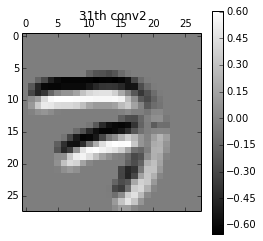

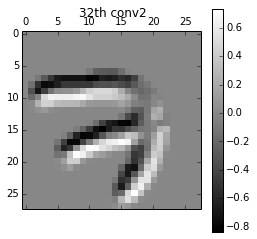

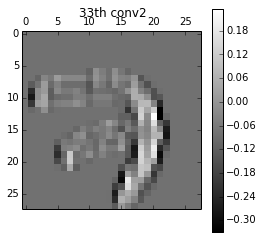

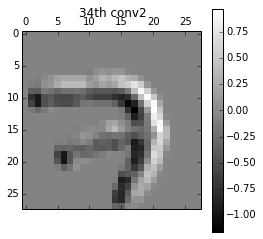

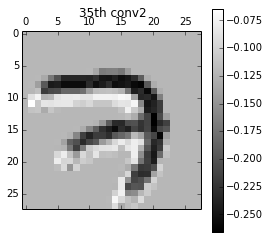

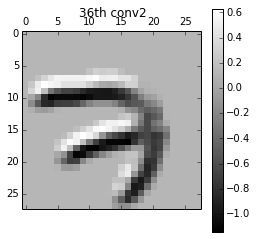

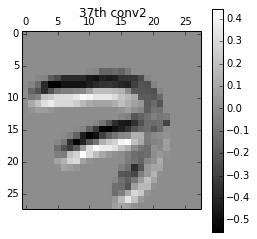

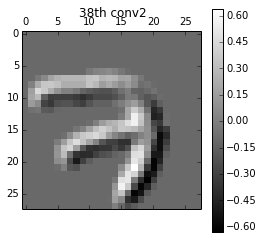

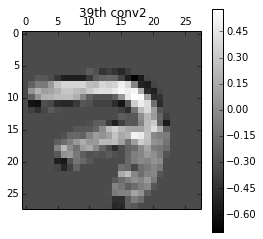

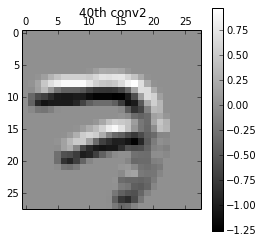

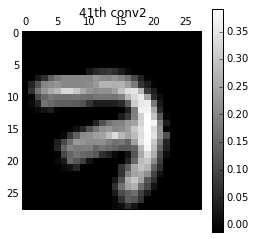

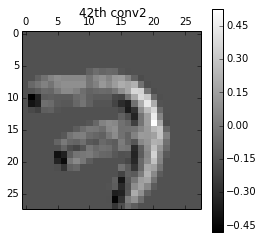

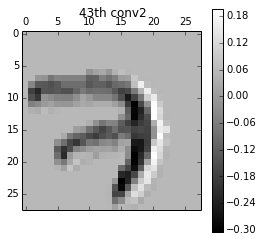

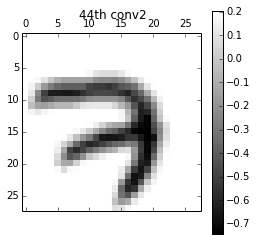

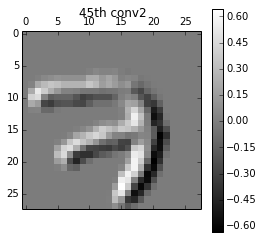

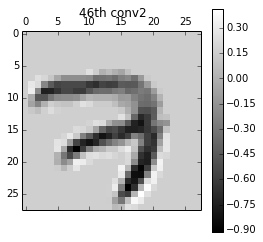

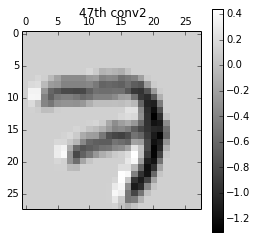

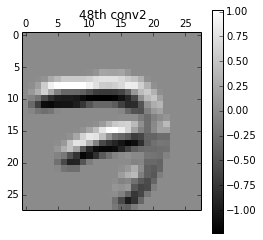

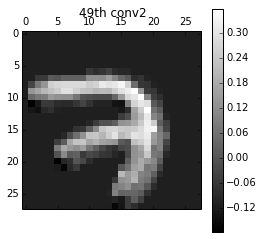

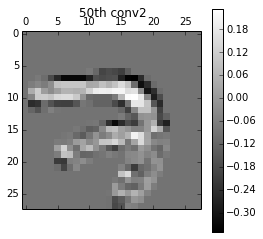

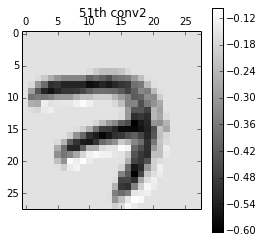

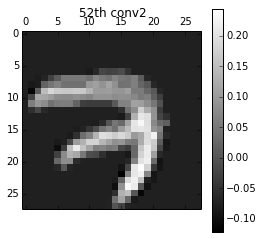

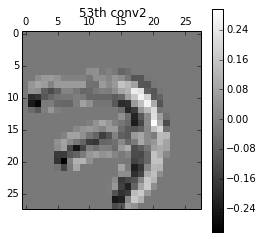

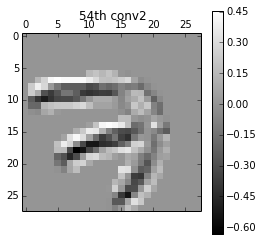

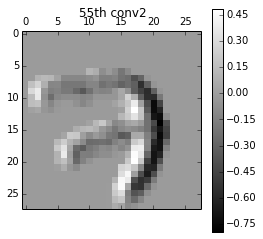

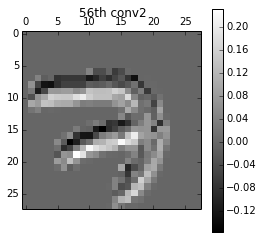

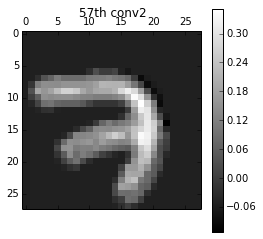

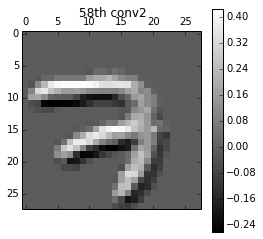

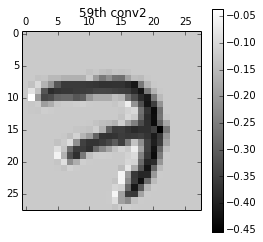

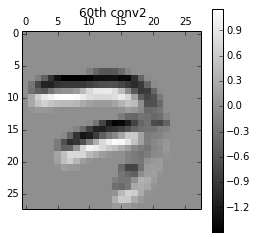

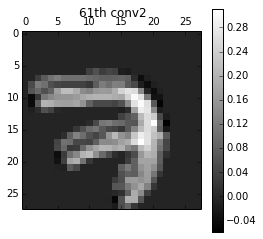

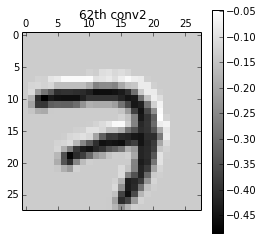

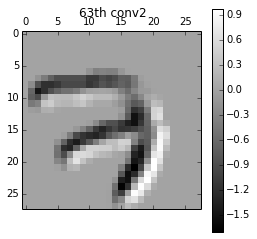

In [10]:
# Let's see 'conv2'
print ("Size of 'conv2' is %s" % (conv2.shape,))

# Plot ! 
for i in range(64):
    plt.matshow(conv2[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv2")
    plt.colorbar()
    plt.show() 

# Conv3 (ReLU)

Size of 'conv3' is (1, 28, 28, 64)


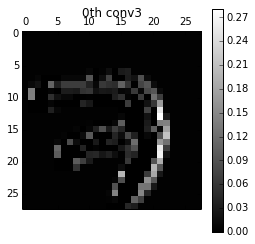

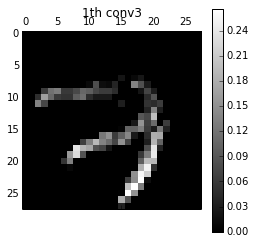

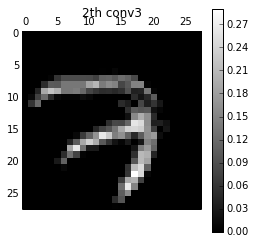

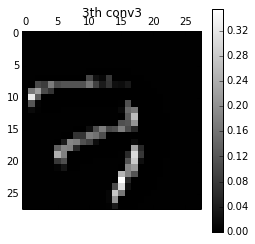

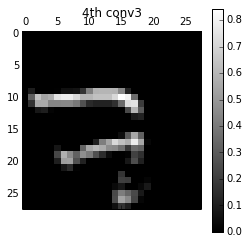

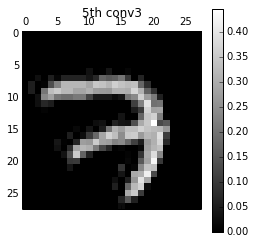

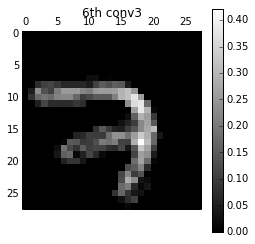

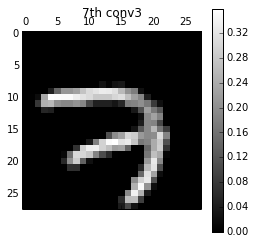

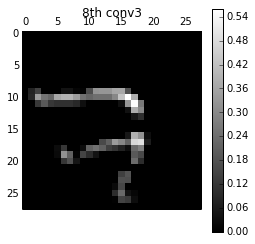

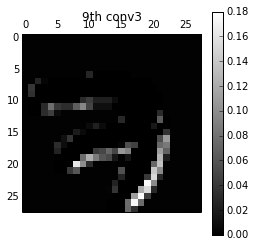

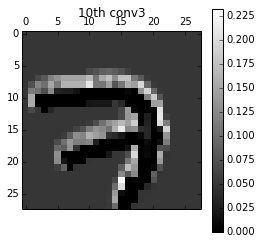

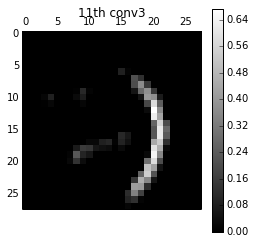

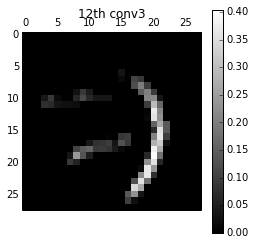

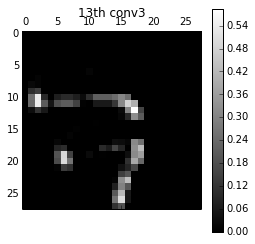

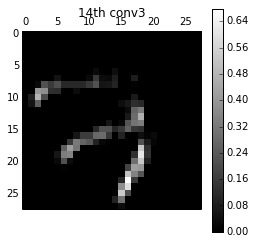

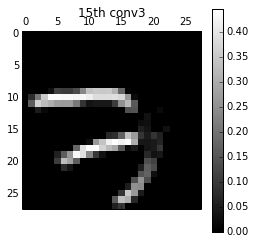

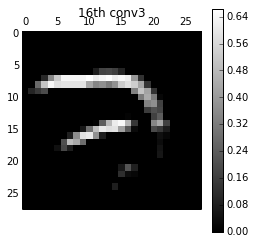

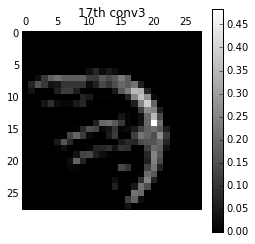

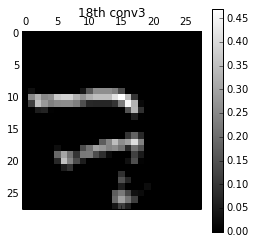

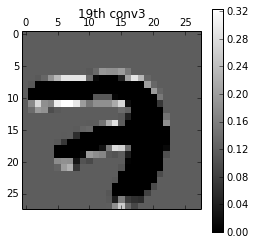

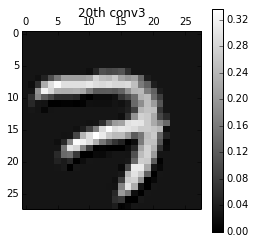

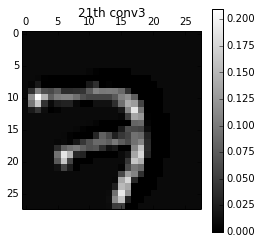

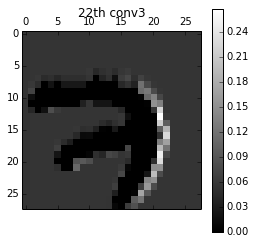

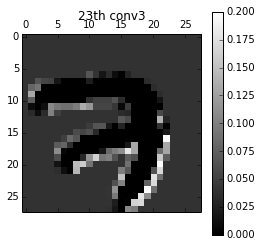

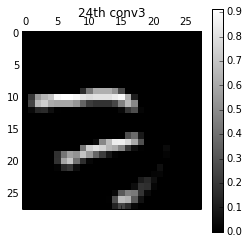

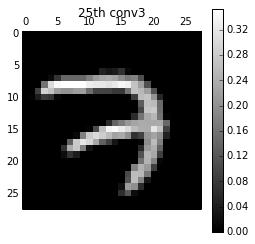

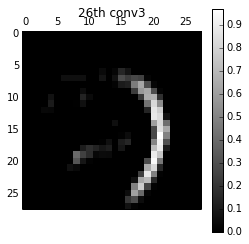

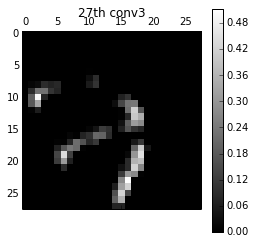

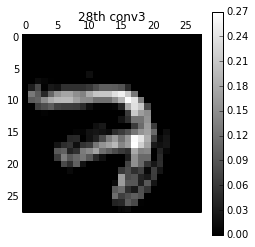

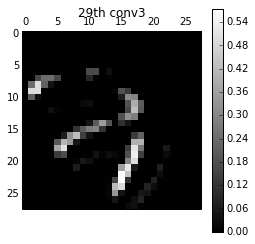

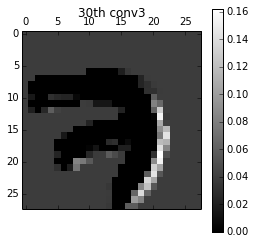

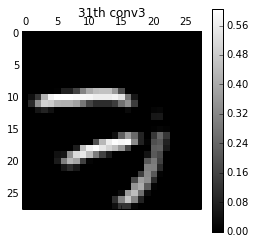

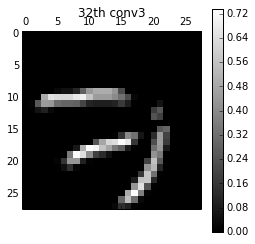

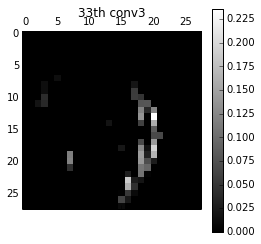

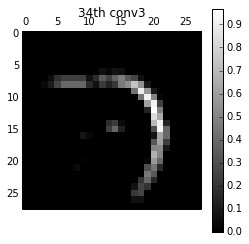

/usr/lib/pymodules/python2.7/matplotlib/colorbar.py:829: RuntimeWarning: invalid value encountered in divide
  z = np.take(y, i0) + (xn - np.take(b, i0)) * dy / db
/usr/lib/pymodules/python2.7/matplotlib/colorbar.py:581: RuntimeWarning: invalid value encountered in greater
  inrange = (ticks > -0.001) & (ticks < 1.001)
/usr/lib/pymodules/python2.7/matplotlib/colorbar.py:581: RuntimeWarning: invalid value encountered in less
  inrange = (ticks > -0.001) & (ticks < 1.001)


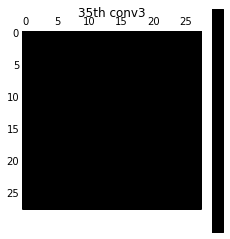

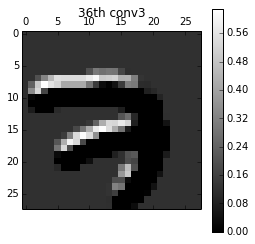

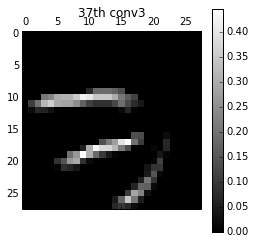

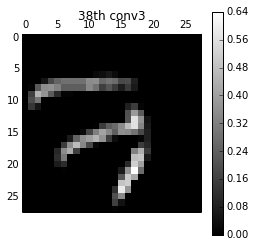

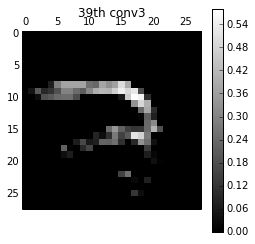

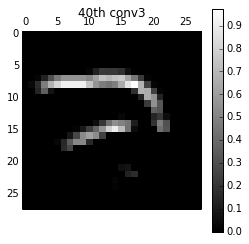

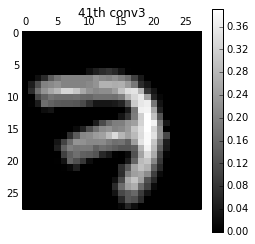

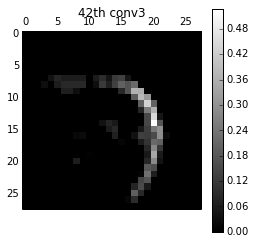

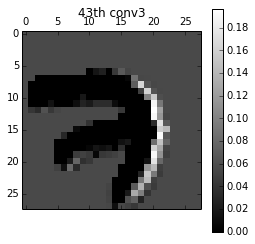

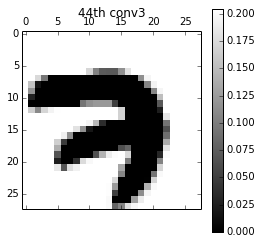

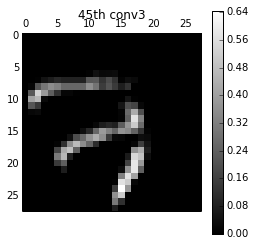

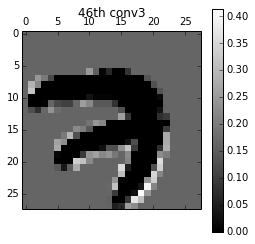

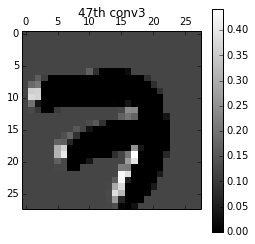

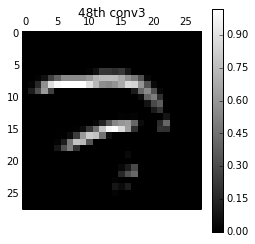

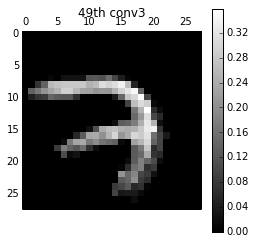

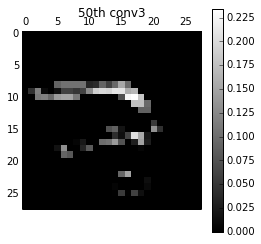

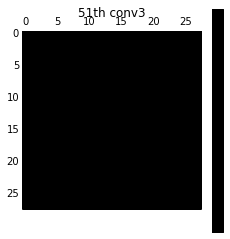

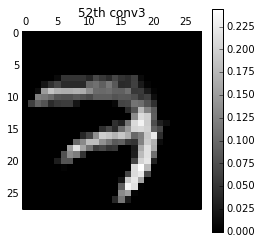

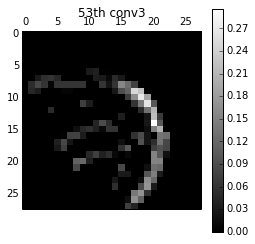

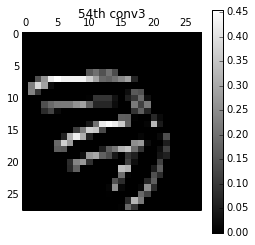

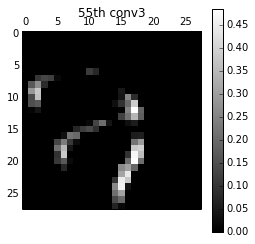

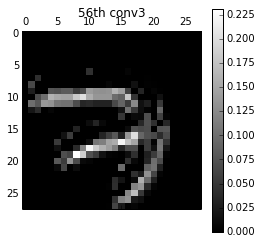

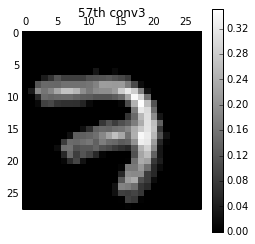

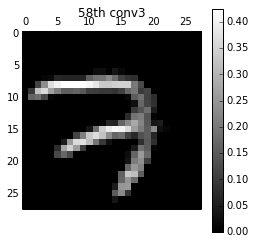

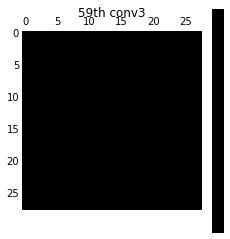

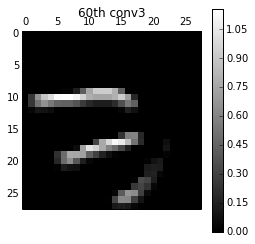

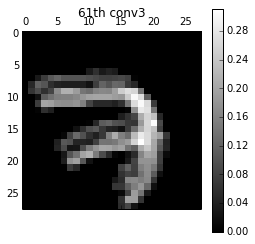

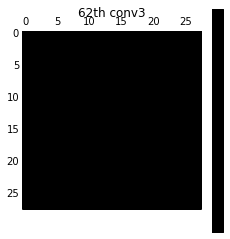

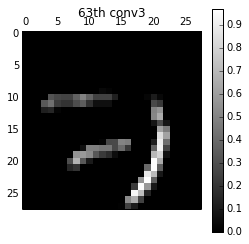

In [11]:
# Let's see 'conv3'
print ("Size of 'conv3' is %s" % (conv3.shape,))

# Plot ! 
for i in range(64):
    plt.matshow(conv3[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv3")
    plt.colorbar()
    plt.show() 

# Pool (max_pool)

Size of 'pool' is (1, 14, 14, 64)


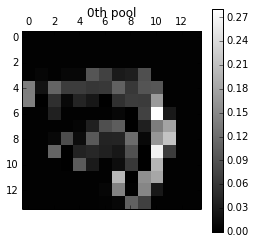

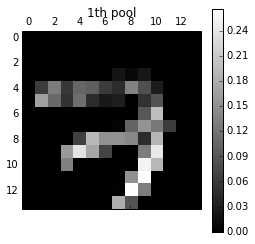

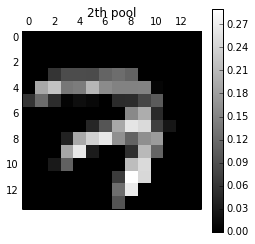

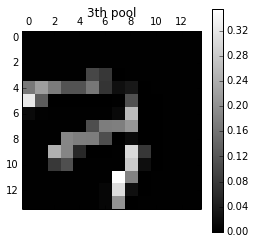

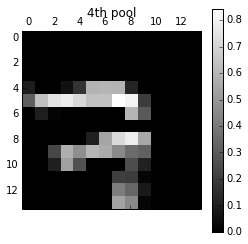

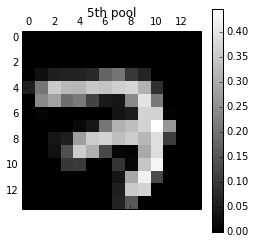

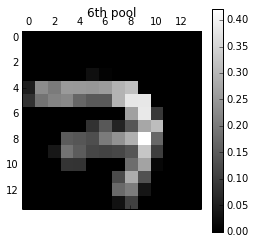

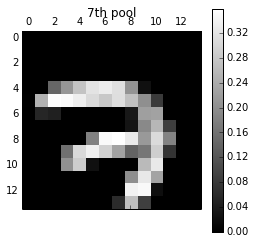

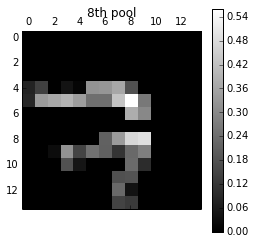

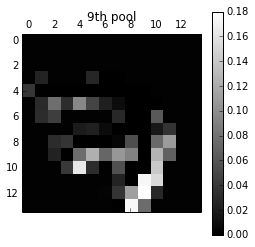

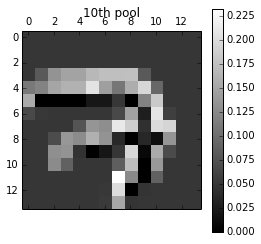

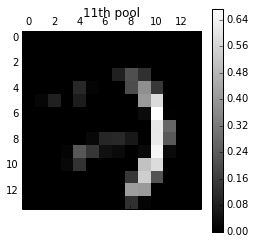

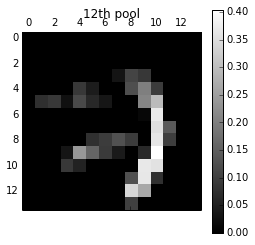

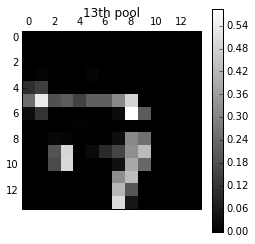

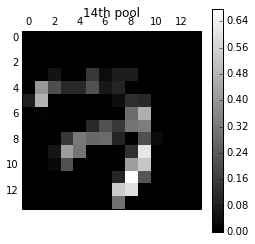

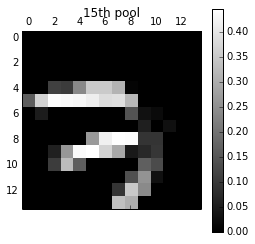

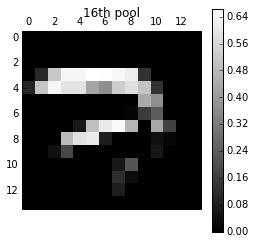

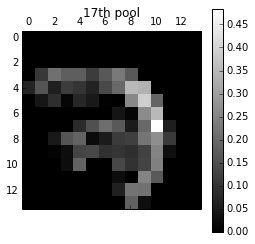

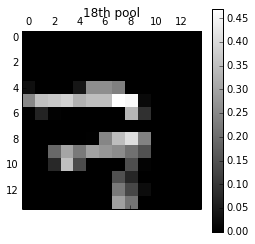

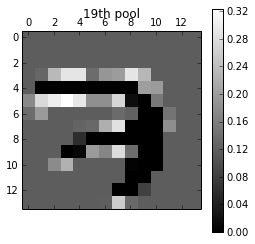

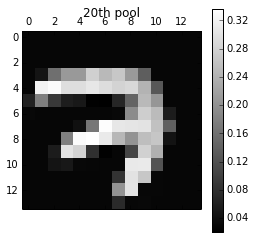

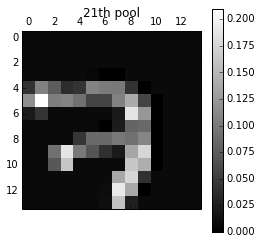

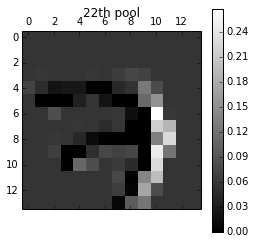

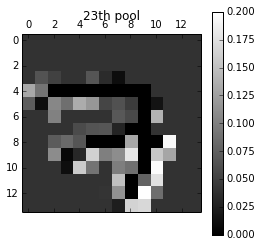

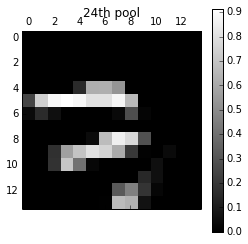

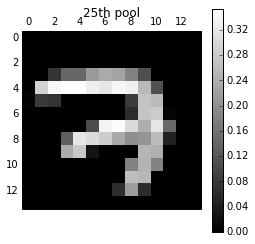

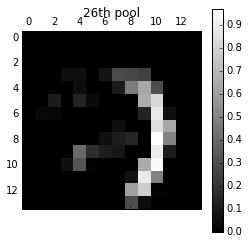

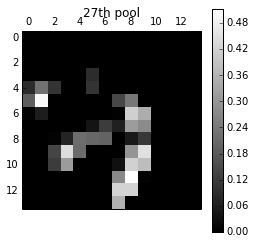

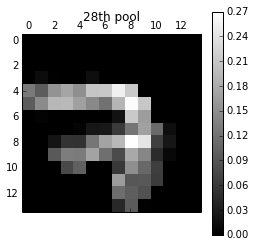

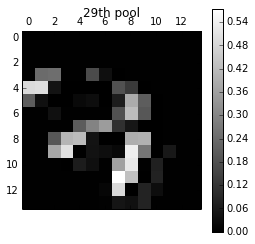

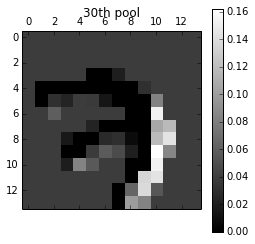

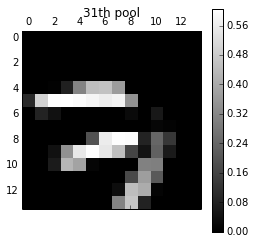

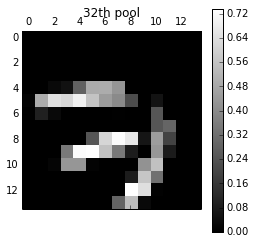

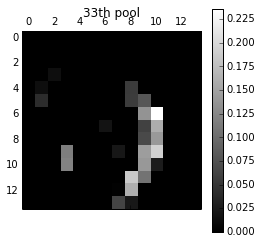

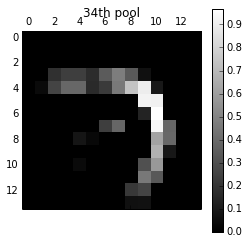

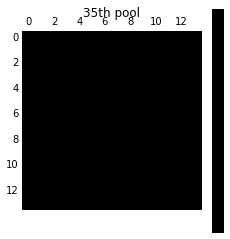

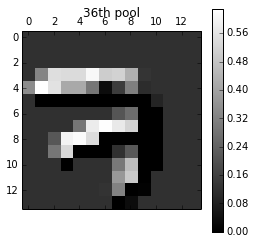

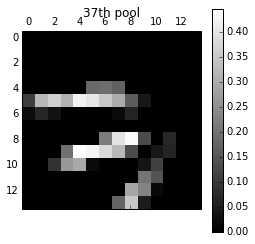

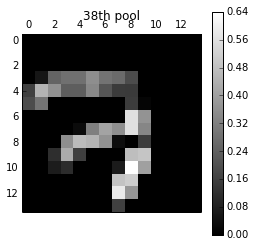

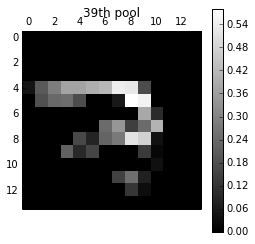

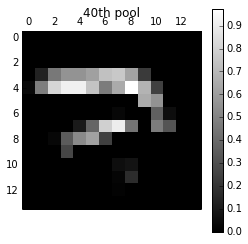

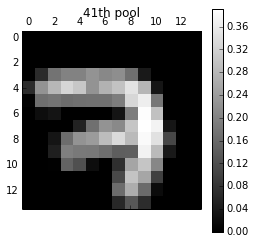

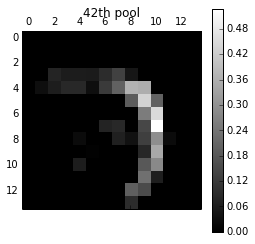

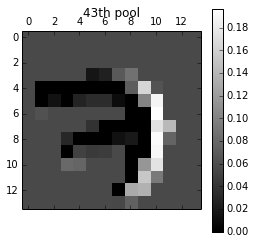

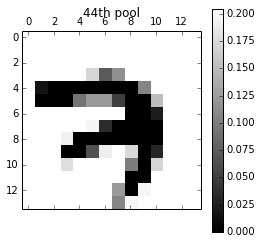

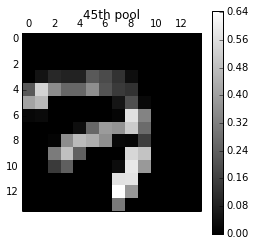

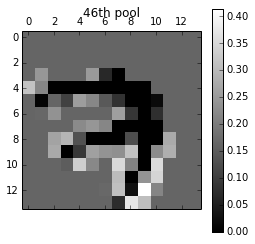

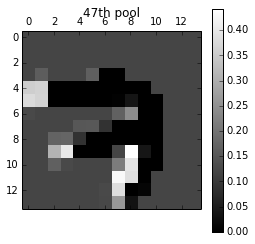

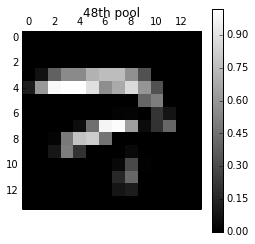

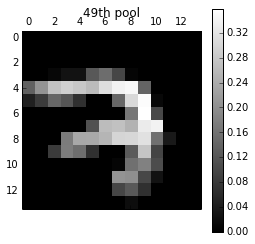

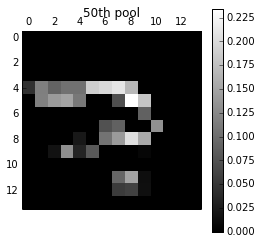

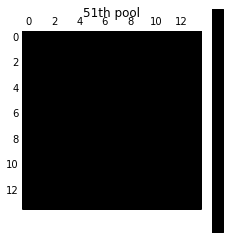

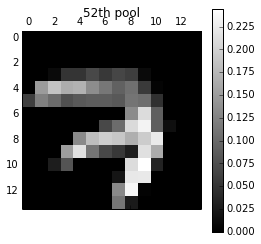

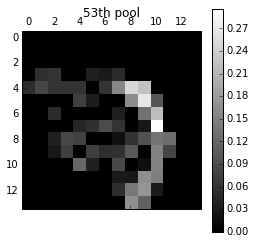

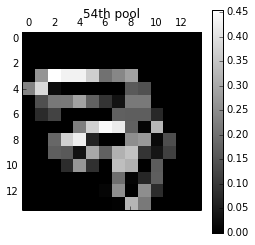

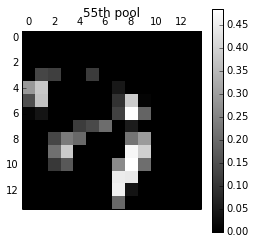

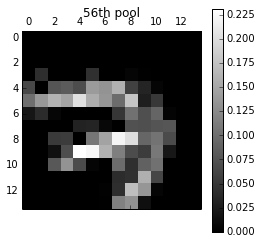

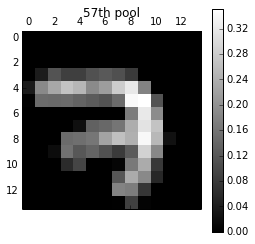

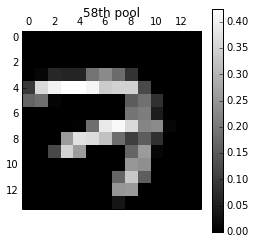

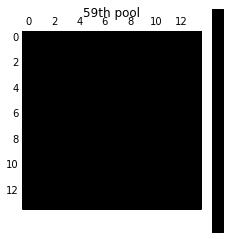

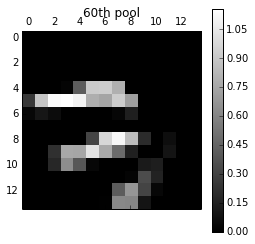

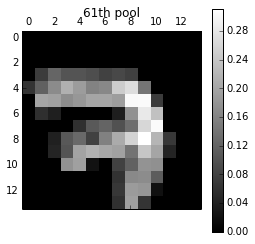

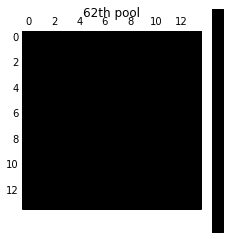

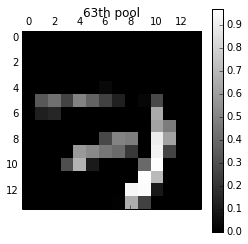

In [12]:
# Let's see 'pool'
print ("Size of 'pool' is %s" % (pool.shape,))

# Plot ! 
for i in range(64):
    plt.matshow(pool[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th pool")
    plt.colorbar()
    plt.show() 

# Dense

In [13]:
# Let's see 'dense'
print ("Size of 'dense' is %s" % (dense.shape,))
# Let's see 'out'
print ("Size of 'out' is %s" % (out.shape,))

Size of 'dense' is (1, 12544)
Size of 'out' is (1, 10)


# Convolution filters

Size of 'wc1' is (3, 3, 1, 64)


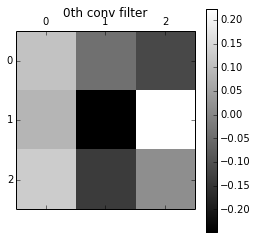

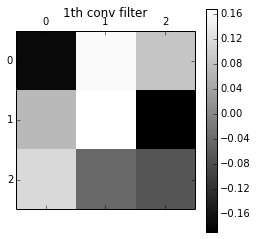

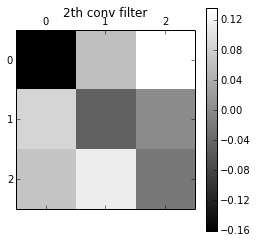

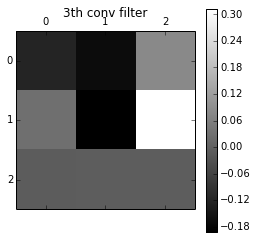

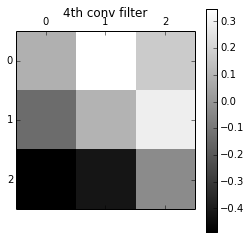

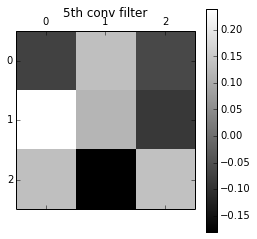

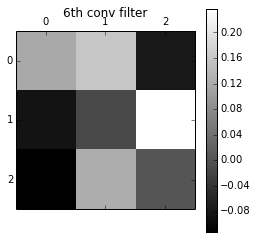

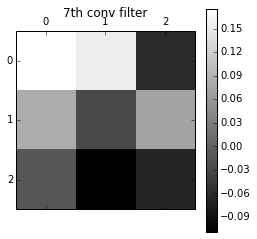

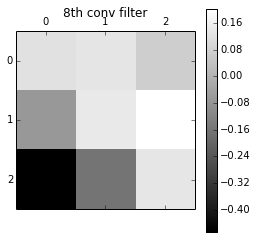

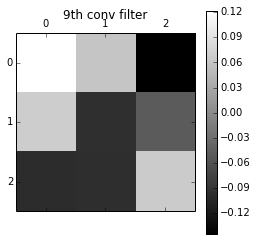

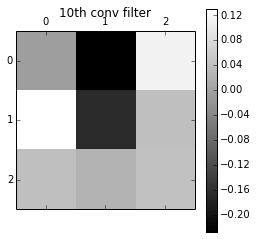

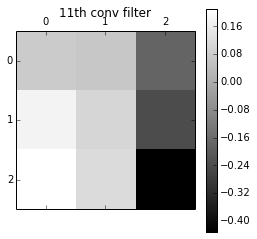

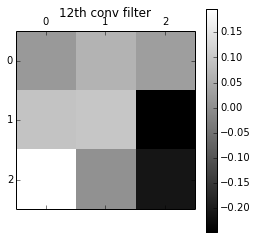

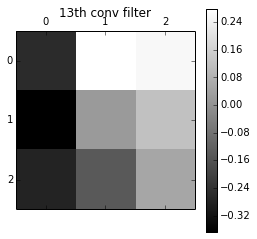

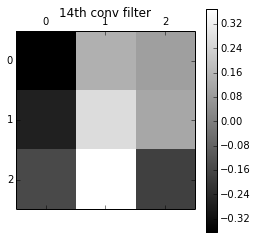

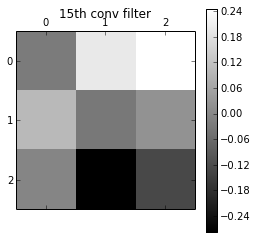

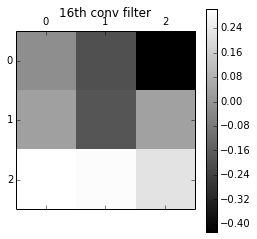

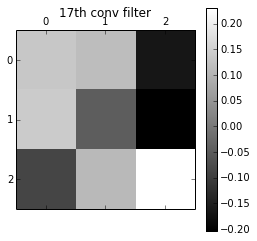

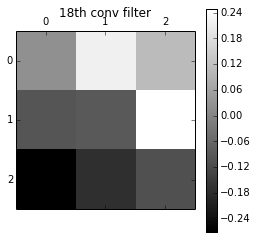

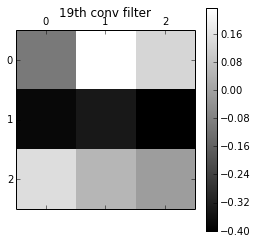

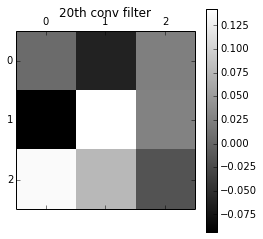

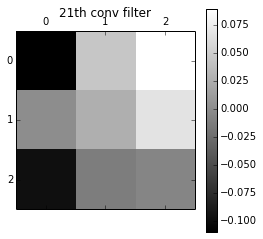

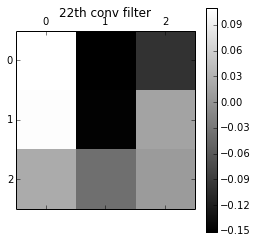

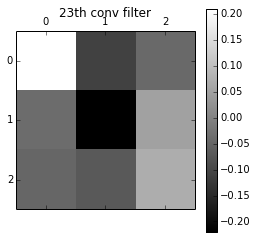

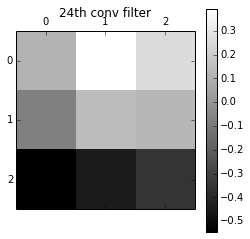

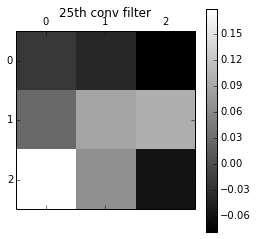

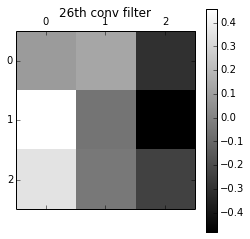

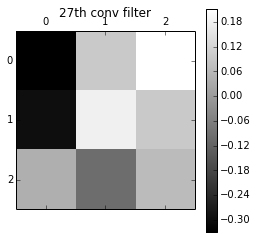

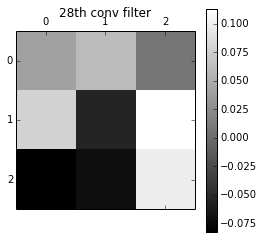

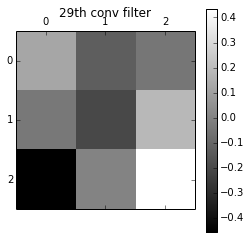

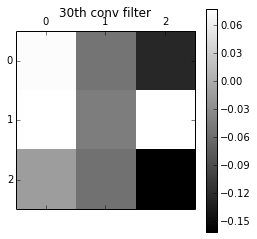

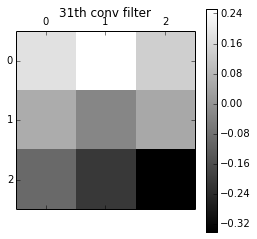

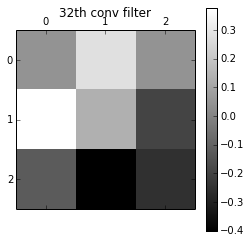

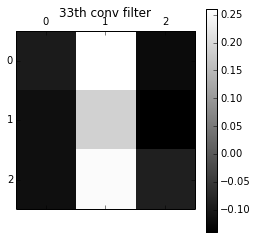

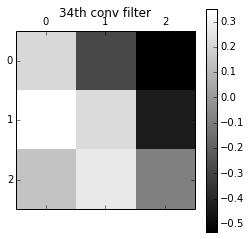

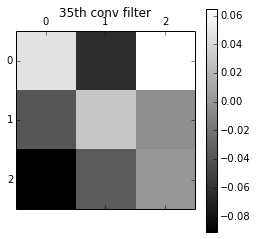

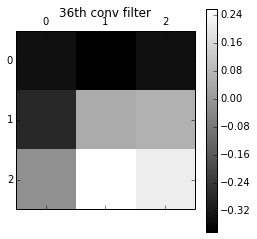

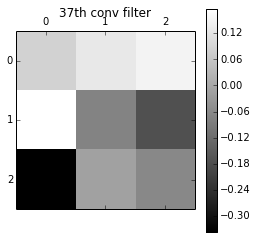

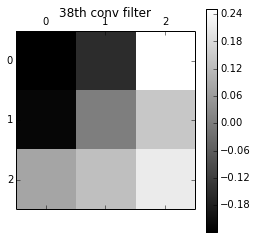

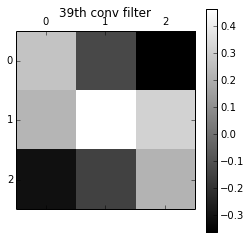

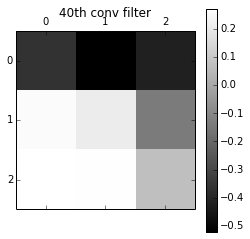

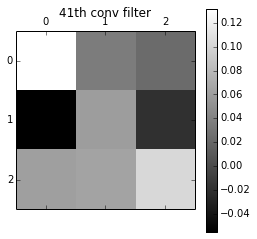

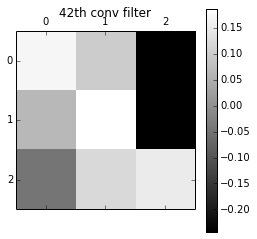

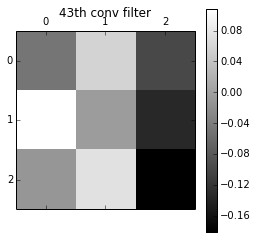

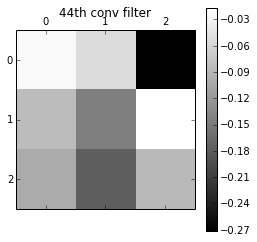

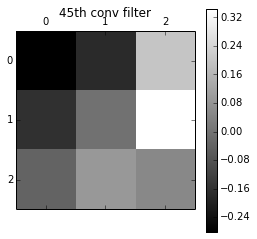

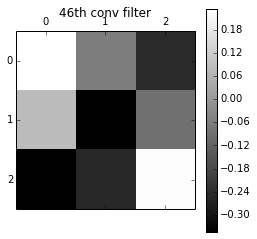

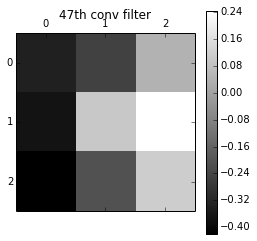

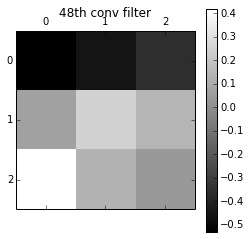

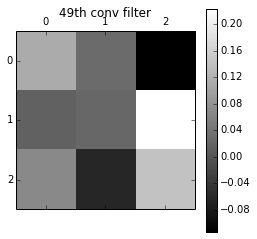

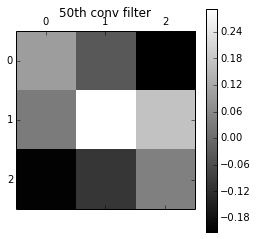

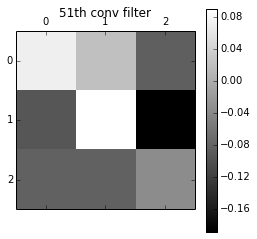

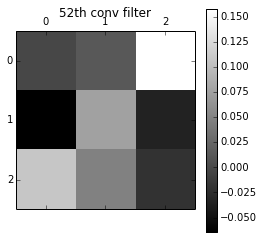

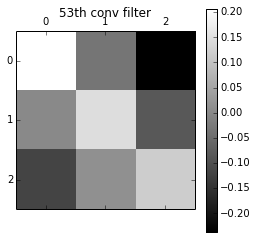

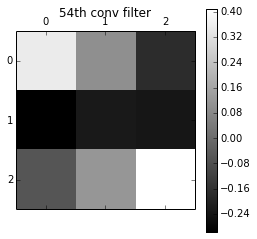

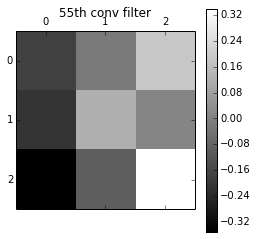

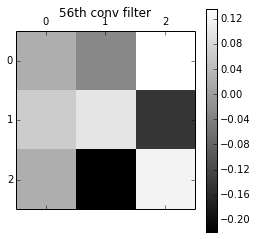

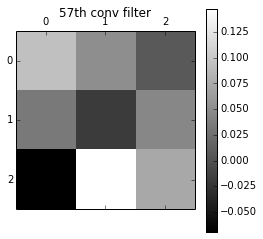

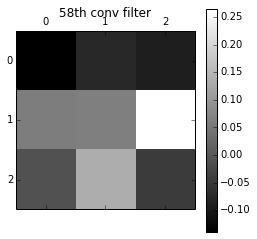

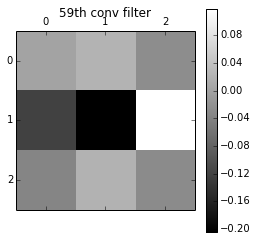

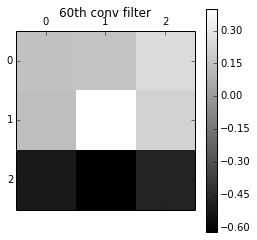

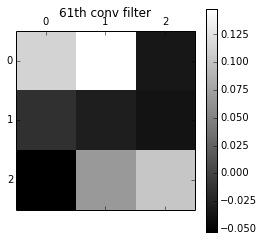

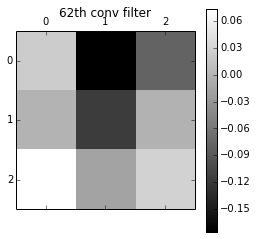

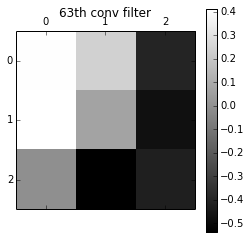

In [14]:
# Let's see weight! 
wc1 = sess.run(weights['wc1'])
print ("Size of 'wc1' is %s" % (wc1.shape,))

# Plot ! 
for i in range(64):
    plt.matshow(wc1[:, :, 0, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv filter")
    plt.colorbar()
    plt.show() 